In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [3]:
df = pd.read_csv("data.csv")
df.drop(columns = ["SYM_ROOT"], inplace = True)
df.columns = ["Date", "Symbol", "Close", "Open", "Low", "High", "Avg", "Vol", "Intraday Volatility", "Variance Ratio (5 min)"]
df.isnull().sum()

Date                      0
Symbol                    0
Close                     0
Open                      0
Low                       0
High                      0
Avg                       0
Vol                       0
Intraday Volatility       0
Variance Ratio (5 min)    0
dtype: int64

In [4]:
df["Date"] = pd.to_datetime(df["Date"])
df.set_index("Date", inplace = True)
df.head()

,Symbol,Close,Open,Low,High,Avg,Vol,Intraday Volatility,Variance Ratio (5 min)
Date,,,,,,,,,
2023-01-03,AAPL,125.07,130.21,124.1667,130.9100,125.923384,106379013,3.192253e-07,0.013734
2023-01-04,AAPL,126.36,127.00,125.0700,140.2858,126.696887,84137393,1.321653e-07,0.326190
2023-01-05,AAPL,125.02,127.07,124.7500,129.7800,126.182508,77229825,2.759356e-07,0.148394
2023-01-06,AAPL,129.62,126.00,124.5100,142.9100,127.957889,82430488,8.851936e-08,0.378660
2023-01-09,AAPL,130.15,130.53,125.0200,133.4188,131.741920,67370452,6.345609e-07,0.261523


In [5]:
df["Realized Variance"]  = df["Intraday Volatility"] * 10_000
df["Log Return"] = np.log(df["Close"] / df["Close"].shift(1))
df = df.dropna(subset=["Log Return", "Realized Variance"])
thresh = 0.5
df = df[df["Log Return"].abs() <= thresh]

In [6]:
dfs = {
    "AAPL": df[df["Symbol"] == "AAPL"],
    "MSFT": df[df["Symbol"] == "MSFT"],
    "TSLA": df[df["Symbol"] == "TSLA"],
    "DIA": df[df["Symbol"] == "DIA"],
    "QQQ": df[df["Symbol"] == "QQQ"],
    "SPY": df[df["Symbol"] == "SPY"]
}

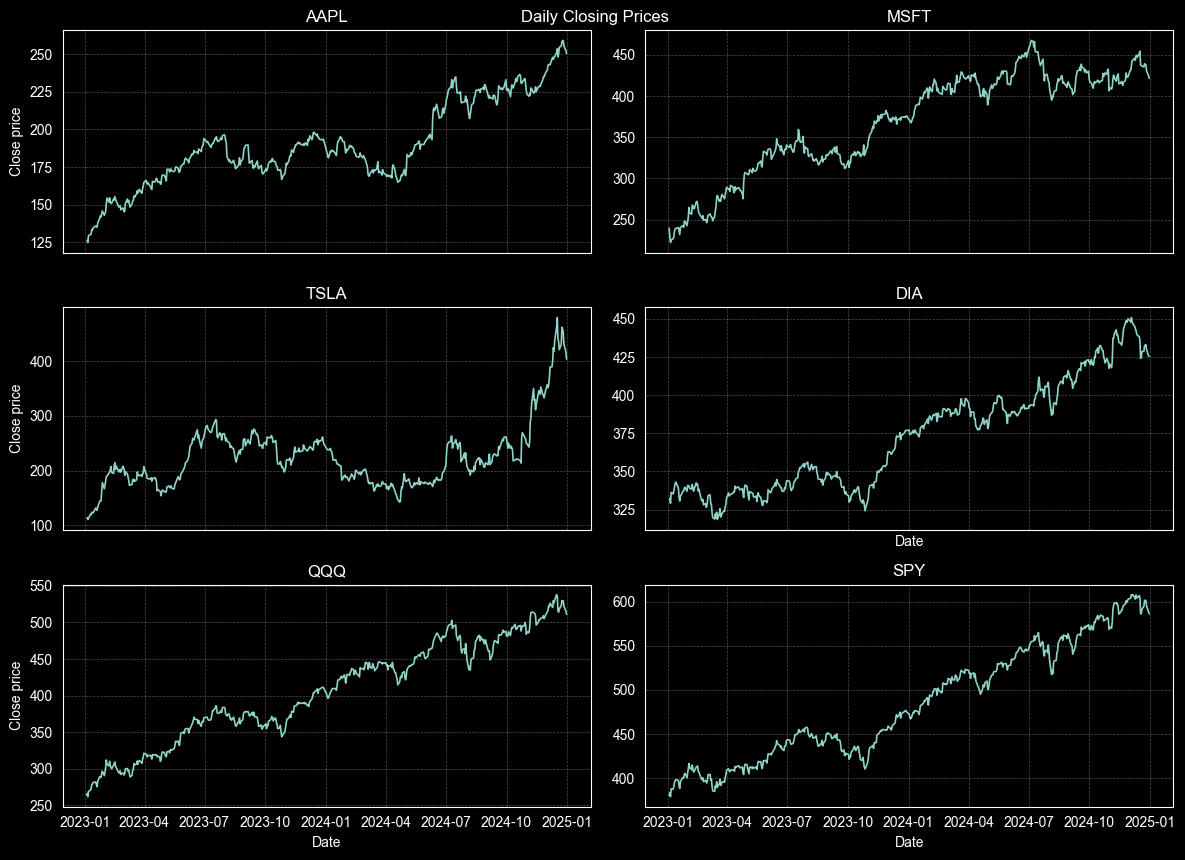

In [7]:
plt.style.use("dark_background")
fig, axes = plt.subplots(3, 2, figsize=(12, 9), sharex=True, sharey=False)
axes = axes.ravel()

for k, (ticker, sub) in enumerate(dfs.items()):
    ax = axes[k]
    ax.plot(sub.index, sub["Close"], lw=1.2)
    ax.set_title(ticker)
    ax.grid(alpha=0.3, linestyle="--", linewidth=0.5)

    if k % 2 == 0:
        ax.set_ylabel("Close price")
    if k >= 3:
        ax.set_xlabel("Date")

fig.suptitle("Daily Closing Prices", y=0.95)
fig.tight_layout()
plt.show()

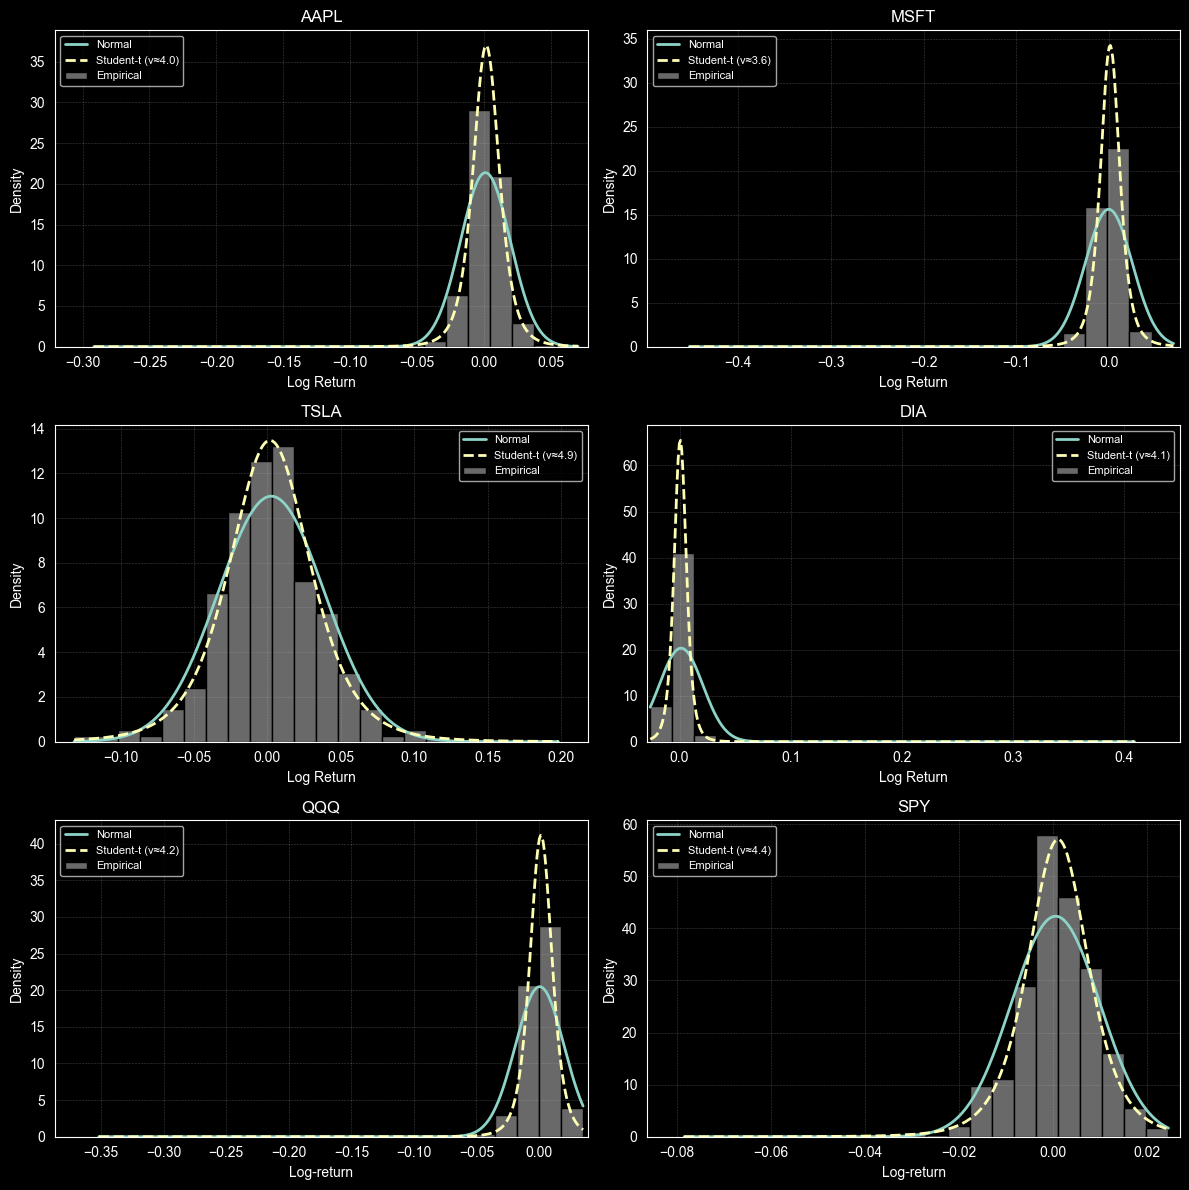

In [23]:
tickers  = list(dfs.keys())
n        = len(tickers)       # 2 columns layout
fig, axes = plt.subplots(3, 2, figsize=(12, 12),
                         sharex=False, sharey=False)
axes = axes.ravel()                  # flatten to 1-D index

for k, ticker in enumerate(tickers):
    sub = dfs[ticker]
    r   = sub["Log Return"].dropna()

    # fit Normal and Student-t
    mu, sigma   = r.mean(), r.std()
    t_params    = stats.t.fit(r)
    x           = np.linspace(r.min(), r.max(), 400)
    normal_pdf  = stats.norm.pdf(x, mu, sigma)
    t_pdf       = stats.t.pdf(x, *t_params)

    ax  = axes[k]
    bins = int(np.sqrt(len(r)))
    sns.histplot(r, bins=bins, stat="density",
                 color="silver", edgecolor="k",
                 alpha=0.55, ax=ax, label="Empirical")

    ax.plot(x, normal_pdf, lw=2, label="Normal")
    ax.plot(x, t_pdf, lw=2, ls="--",
            label=f"Student-t (ν≈{t_params[0]:.1f})")

    ax.set_title(ticker)
    ax.set_xlim(r.min()*1.1, r.max()*1.1)
    ax.grid(alpha=0.25, ls="--", lw=0.4)

    if k % 2 == 0:                   # left column
        ax.set_ylabel("Density")
    if k >= 4:              # bottom row
        ax.set_xlabel("Log-return")
    ax.legend(fontsize=8)

# hide empty subplot if odd number of tickers
for j in range(n, 6):
    fig.delaxes(axes[j])

fig.tight_layout()
plt.show()

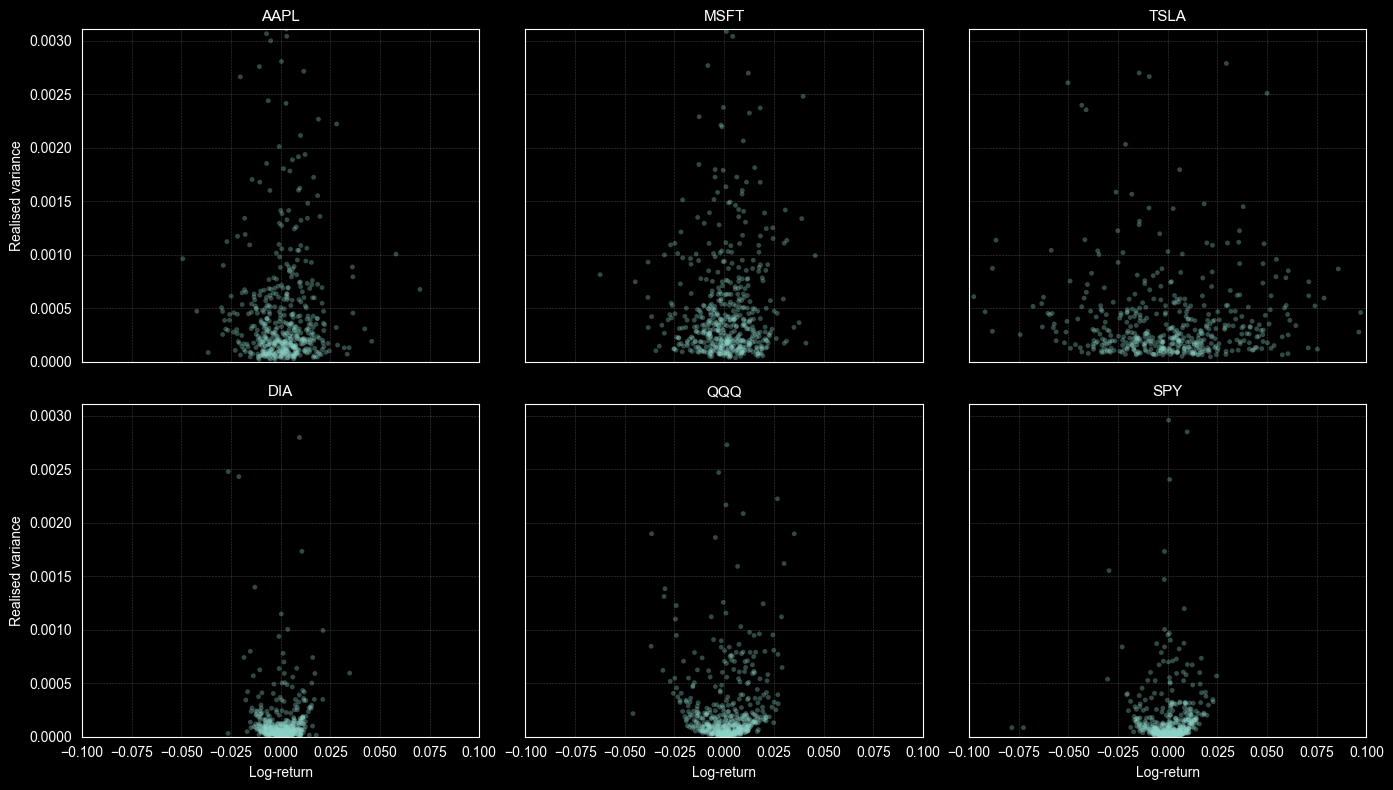

In [31]:
fig, axes = plt.subplots(2, 3, figsize=(14, 8), sharex=True, sharey=True)
axes = axes.ravel()                       # flatten 2×3 → list of 6 axes

for k, (ticker, sub) in enumerate(dfs.items()):
    r  = sub["Log Return"].dropna()
    rv = sub.loc[r.index, "Realized Variance"]

    ax = axes[k]
    ax.scatter(r, rv, s=12, alpha=0.35, edgecolor="none")
    ax.set_title(ticker, fontsize=11)

    # grid & limits for clarity
    ax.grid(alpha=0.25, ls="--", lw=0.4)
    ax.set_xlim(-0.10, 0.10)
    ax.set_ylim(0, rv.max() * 1.05)

    # axis labels only on outer margins
    if k % 3 == 0:
        ax.set_ylabel("Realised variance")
    if k >= 3:
        ax.set_xlabel("Log-return")

# remove any unused axes if dfs has < 6 tickers
for j in range(len(dfs), 6):
    fig.delaxes(axes[j])

fig.tight_layout()
plt.show()

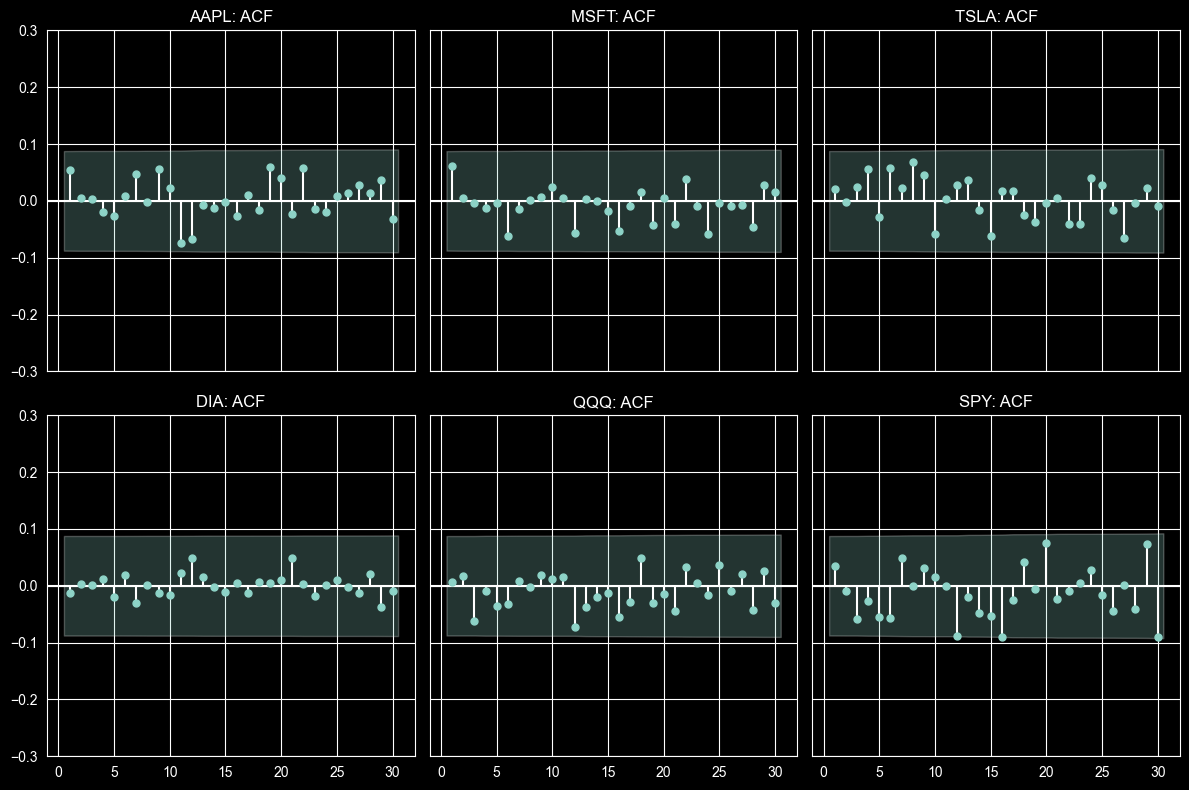

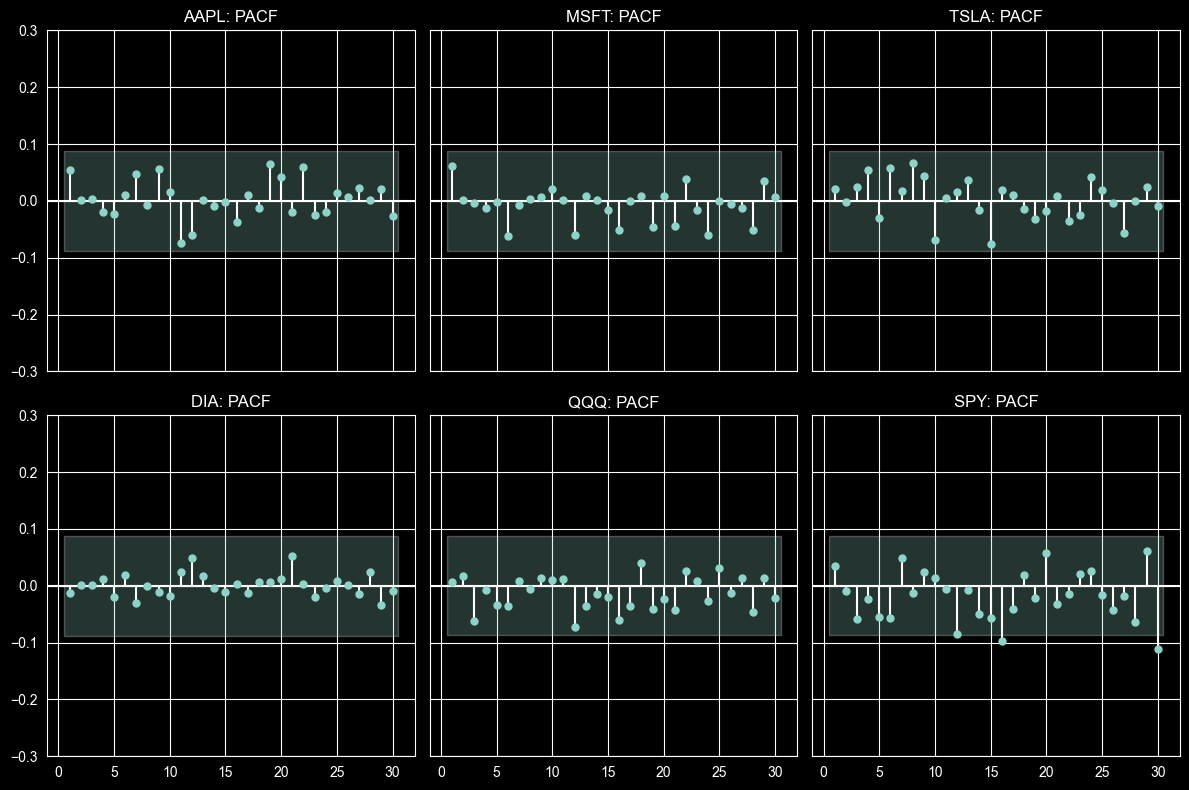

In [34]:
fig_acf, axes_acf = plt.subplots(2, 3, figsize=(12, 8), sharex=True, sharey=True)
axes_acf = axes_acf.ravel()

for k, (ticker, sub) in enumerate(dfs.items()):
    r = sub["Log Return"].dropna()

    plot_acf(r, lags=30, ax=axes_acf[k], zero=False)
    axes_acf[k].set_title(f"{ticker}: ACF")
    axes_acf[k].set_ylim(-0.3, 0.3)          # keeps scale consistent

fig_acf.tight_layout()
fig_acf.savefig("acf.png")
plt.show()

fig_pacf, axes_pacf = plt.subplots(2, 3, figsize=(12, 8), sharex=True, sharey=True)
axes_pacf = axes_pacf.ravel()

for k, (ticker, sub) in enumerate(dfs.items()):
    r = sub["Log Return"].dropna()

    plot_pacf(r, lags=30, ax=axes_pacf[k], method="ywm", zero=False)
    axes_pacf[k].set_title(f"{ticker}: PACF")
    axes_pacf[k].set_ylim(-0.3, 0.3)

fig_pacf.tight_layout()
fig_pacf.savefig("pacf.png")
plt.show()

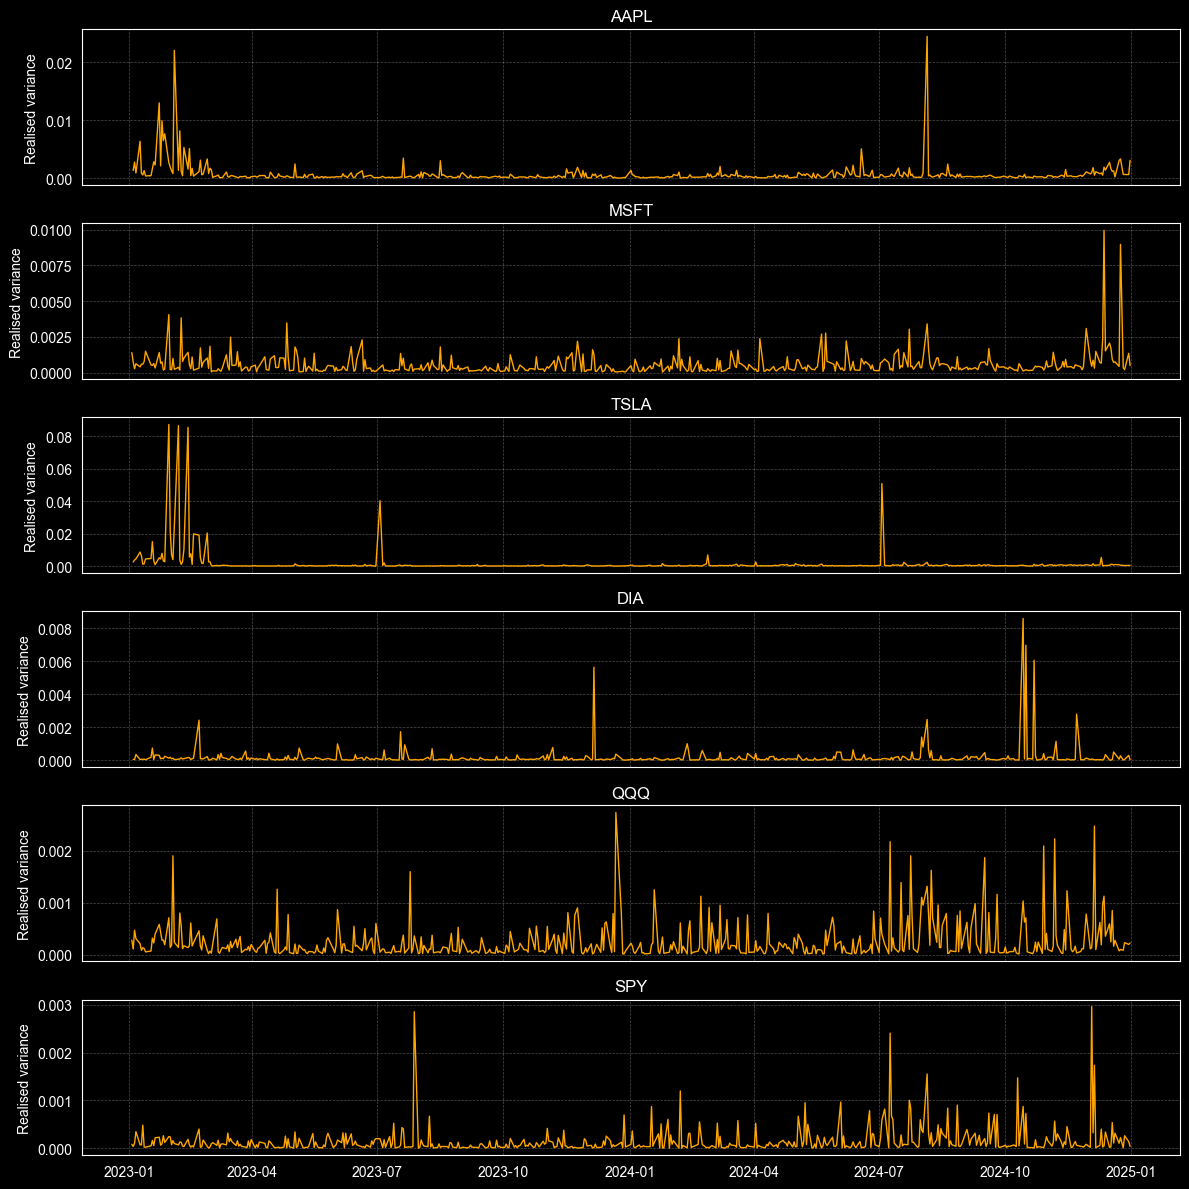

In [37]:
fig, axes = plt.subplots(6, figsize=(12, 12), sharex=True, sharey=False)
axes = axes.ravel()                       # flatten to iterate easily

for k, (ticker, sub) in enumerate(dfs.items()):
    ax = axes[k]
    ax.plot(sub.index, sub["Realized Variance"],
            lw=1.0, color="orange")

    ax.set_title(ticker)
    ax.grid(alpha=0.3, linestyle="--", linewidth=0.5)                      # left column
    ax.set_ylabel("Realised variance")
    if k == 6:                            # bottom row (indices 4 and 5)
        ax.set_xlabel("Date")

fig.tight_layout()
fig.savefig("realized_variance.png")
plt.show()